## Online Retail Data Set 

The dataset in this notebook is taken from UC Irvine's Machine Learning Repository [Online Retail Dataset](https://archive.ics.uci.edu/ml/datasets/online+retail#)

The text below is the explanation of the Online Retail Data Set from the website

### Data Set Information:

This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

### Attribute Information:

- InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.
- StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
- Description: Product (item) name. Nominal.
- Quantity: The quantities of each product (item) per transaction. Numeric.
- InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated.
- UnitPrice: Unit price. Numeric, Product price per unit in sterling.
- CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
- Country: Country name. Nominal, the name of the country where each customer resides.


In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_excel('Online Retail.xlsx')

In [3]:
df.shape

(541909, 8)

In [4]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


Analysis on transaction datasets such as these are
1. Exploratory Data Analysis 
2. Customer Segmentation
3. Market Basket Analysis
4. Time Series Analysis

However, based on the brief description of the dataset most of the customers are wholesalers, thus, the market basket analysis is not really suitable since wholesalers buy in large quantities to resale to other customers and not the purpose of masket basket analysis. We can try to differentiate first between the wholesalers and individual customers then apply market basket analysis to the individual customers

### Dataset Cleaning

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


we can see some points have null values

In [7]:
null_count = df.isnull().sum()
null_count

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

The null values are only in description and CustomerID (my current guess is that no CustomerID might be the wholeshale? who knows might be)

In [8]:
df.shape

(541909, 8)

In [9]:
df[df["Quantity"] <= 0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397.0,United Kingdom
541541,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498.0,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311.0,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315.0,United Kingdom


some quantities have <= 0 values which are unsual. However, from the first row it states StockCode - D Discount and some are M Manual. Lets do a deeper analysis

In [10]:
stockcode_unique = pd.Series(df["StockCode"].unique())
non_numeric_stockcode = stockcode_unique[~pd.to_numeric(stockcode_unique, errors='coerce').notnull()]

In [11]:
non_numeric_stockcode

0       85123A
2       84406B
3       84029G
4       84029E
45        POST
         ...  
4055    84971l
4056    85034b
4065    85179a
4067    90214U
4068    47591b
Length: 1124, dtype: object

We can see that there are 1124 unique StockCode that are non-numeric. Lets try analying using regex

In [12]:
import re

In [13]:
only_letters = '^[a-zA-Z]+$'
letter_then_num = '^[a-zA-Z]+[0-9]+$'
num_then_letter = '^[0-9]+[a-zA-Z]+$'

In [14]:
only_letters_stockcode = non_numeric_stockcode[non_numeric_stockcode.str.contains(only_letters)]
letter_then_num_stockcode = non_numeric_stockcode[non_numeric_stockcode.str.contains(letter_then_num)]
num_then_letter_stockcode = non_numeric_stockcode[non_numeric_stockcode.str.contains(num_then_letter)]

In [15]:
only_letters_stockcode

45           POST
111             D
952           DOT
1115            M
2242            S
2245    AMAZONFEE
2791            m
3078     DCGSSBOY
3079    DCGSSGIRL
3328         PADS
3753            B
3772         CRUK
dtype: object

In [16]:
letter_then_num_stockcode

773           C2
2441    DCGS0076
2539    DCGS0003
2786    DCGS0070
3014    DCGS0055
3015    DCGS0072
3016    DCGS0074
3018    DCGS0069
3038    DCGS0057
3385    DCGS0004
3710    DCGS0073
3711    DCGS0071
3712    DCGS0068
3713    DCGS0067
dtype: object

In [17]:
num_then_letter_stockcode

0       85123A
2       84406B
3       84029G
4       84029E
55      82494L
         ...  
4055    84971l
4056    85034b
4065    85179a
4067    90214U
4068    47591b
Length: 1091, dtype: object

In [18]:
non_numeric_stockcode.shape[0] - (only_letters_stockcode.shape[0] + letter_then_num_stockcode.shape[0] + num_then_letter_stockcode.shape[0])

7

There are seven non numeric stockcodes left we can just filter them out

In [19]:
rest_stockcode = non_numeric_stockcode[~non_numeric_stockcode.isin(pd.concat([only_letters_stockcode,letter_then_num_stockcode,num_then_letter_stockcode]))]

In [21]:
rest_stockcode

1542    BANK CHARGES
2774    gift_0001_40
2815    gift_0001_50
2842    gift_0001_30
2843    gift_0001_20
3197    gift_0001_10
3714       DCGS0066P
dtype: object

Lets see what some of these mean

In [24]:
df[df["StockCode"] == 'gift_0001_20'].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
44794,540238,gift_0001_20,Dotcomgiftshop Gift Voucher £20.00,1,2011-01-05 14:44:00,17.02,NaN,United Kingdom
55589,540995,gift_0001_20,Dotcomgiftshop Gift Voucher £20.00,1,2011-01-13 09:30:00,16.67,NaN,United Kingdom
91278,544089,gift_0001_20,Dotcomgiftshop Gift Voucher £20.00,1,2011-02-15 17:51:00,16.67,NaN,United Kingdom
161388,550474,gift_0001_20,Dotcomgiftshop Gift Voucher £20.00,2,2011-04-18 13:58:00,16.67,NaN,United Kingdom
163440,550542,gift_0001_20,Dotcomgiftshop Gift Voucher £20.00,1,2011-04-19 11:37:00,16.67,NaN,United Kingdom


so gift_0001_XX is gift vouchers of XX in pounds

In [28]:
df[df["StockCode"] == 'gift_0001_10'].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
112442,545895,gift_0001_10,Dotcomgiftshop Gift Voucher £10.00,1,2011-03-07 17:14:00,8.33,NaN,United Kingdom
163439,550542,gift_0001_10,Dotcomgiftshop Gift Voucher £10.00,1,2011-04-19 11:37:00,8.33,NaN,United Kingdom
191910,553387,gift_0001_10,Dotcomgiftshop Gift Voucher £10.00,1,2011-05-16 16:33:00,8.33,NaN,United Kingdom
192071,553389,gift_0001_10,Dotcomgiftshop Gift Voucher £10.00,1,2011-05-16 16:37:00,8.33,NaN,United Kingdom
245515,558614,gift_0001_10,Dotcomgiftshop Gift Voucher £10.00,1,2011-06-30 15:56:00,8.33,NaN,United Kingdom


In [29]:
df[df["StockCode"] == 'C2'].head() #C2 might be carriage cost, thus we remove

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
1423,536540,C2,CARRIAGE,1,2010-12-01 14:05:00,50.0,14911.0,EIRE
12119,537368,C2,CARRIAGE,1,2010-12-06 12:40:00,50.0,14911.0,EIRE
12452,537378,C2,CARRIAGE,1,2010-12-06 13:06:00,50.0,14911.0,EIRE
19975,537963,C2,CARRIAGE,1,2010-12-09 11:30:00,50.0,13369.0,United Kingdom
20016,538002,C2,CARRIAGE,1,2010-12-09 11:48:00,50.0,14932.0,Channel Islands


In [30]:
df[df["StockCode"] == 'BANK CHARGES'].head() #bank charges remove as well

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
4406,536779,BANK CHARGES,Bank Charges,1,2010-12-02 15:08:00,15.00,15823.0,United Kingdom
14435,C537572,BANK CHARGES,Bank Charges,-1,2010-12-07 12:00:00,95.38,NaN,United Kingdom
28992,C538680,BANK CHARGES,Bank Charges,-1,2010-12-13 17:10:00,966.92,NaN,United Kingdom
62508,541505,BANK CHARGES,Bank Charges,1,2011-01-18 15:58:00,15.00,15939.0,United Kingdom
64573,C541653,BANK CHARGES,Bank Charges,-1,2011-01-20 11:50:00,1050.15,NaN,United Kingdom


In [31]:
df[df["StockCode"] == 'DCGS0074'].head() # DCGS0074 is not valid item code but the some are

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
74839,542532,DCGS0074,NaN,-1,2011-01-28 13:09:00,0.0,NaN,United Kingdom


In [32]:
df[df["StockCode"] == 'DCGS0076'].head() 

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
21326,538071,DCGS0076,SUNJAR LED NIGHT NIGHT LIGHT,1,2010-12-09 14:09:00,16.13,NaN,United Kingdom
39313,539631,DCGS0076,SUNJAR LED NIGHT NIGHT LIGHT,2,2010-12-20 15:03:00,16.13,NaN,United Kingdom


In [33]:
df[df["StockCode"] == 'DCGS0067']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
279256,561254,DCGS0067,ebay,-11,2011-07-26 11:52:00,0.0,NaN,United Kingdom


In [34]:
df[df["StockCode"] == 'DCGSSBOY']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
84016,543358,DCGSSBOY,BOYS PARTY BAG,1,2011-02-07 14:04:00,3.29,NaN,United Kingdom
97246,544599,DCGSSBOY,BOYS PARTY BAG,1,2011-02-21 18:15:00,3.29,NaN,United Kingdom
112723,545897,DCGSSBOY,BOYS PARTY BAG,5,2011-03-07 17:22:00,3.29,NaN,United Kingdom
116891,546306,DCGSSBOY,BOYS PARTY BAG,1,2011-03-10 16:16:00,3.29,NaN,United Kingdom
128107,547249,DCGSSBOY,BOYS PARTY BAG,6,2011-03-22 09:27:00,3.29,NaN,United Kingdom
160487,550458,DCGSSBOY,BOYS PARTY BAG,1,2011-04-18 13:13:00,3.29,NaN,United Kingdom
178669,552234,DCGSSBOY,BOYS PARTY BAG,7,2011-05-06 16:01:00,3.29,NaN,United Kingdom
262771,559923,DCGSSBOY,BOYS PARTY BAG,20,2011-07-13 16:07:00,3.29,NaN,United Kingdom
278378,561209,DCGSSBOY,BOYS PARTY BAG,2,2011-07-25 16:57:00,1.25,NaN,United Kingdom
365966,568716,DCGSSBOY,BOYS PARTY BAG,2,2011-09-28 16:13:00,3.29,NaN,United Kingdom


we can just remove first which have quantity <= 0 and filter accordingly

In [35]:
df_cut = df[df["Quantity"] > 0]

In [37]:
df_cut = df_cut[~df_cut['StockCode'].isin(pd.concat([only_letters_stockcode, rest_stockcode, num_then_letter_stockcode]))] 
# lets just remove all stockcodes which are in non_numeric_stockcodes except num_then_letter_stockcode

In [38]:
df_cut = df_cut[df_cut['UnitPrice'] > 0]

In [39]:
df_cut['TotalPrice'] = df_cut['Quantity'] * df_cut['UnitPrice']

In [41]:
df_cut

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom,15.30
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom,25.50
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom,11.10
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom,11.10
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,10.20
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12.60
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60


Let's group by the relevant columns

In [127]:
df_invoice_group = df_cut.groupby('InvoiceNo').sum()
df_stockcode_group = df_cut.groupby('StockCode').sum()
df_country_group = df_cut.groupby('Country').sum()

In [141]:
import matplotlib.pyplot as plt

In [142]:
df_invoice_group.describe()

,Quantity,UnitPrice,CustomerID,TotalPrice
count,19553.000000,19553.000000,1.955300e+04,19553.000000
mean,262.429550,80.233679,2.841334e+05,479.473548
std,947.989251,174.319468,3.467765e+05,1732.525685
min,1.000000,0.040000,0.000000e+00,0.420000
25%,64.000000,16.480000,6.928000e+04,138.430000
50%,141.000000,40.950000,1.933030e+05,272.900000
75%,276.000000,81.700000,3.678840e+05,448.950000
max,80995.000000,4478.700000,6.836560e+06,168469.600000


{'whiskers': [<matplotlib.lines.Line2D at 0x20b6e618f10>,
 'caps': [<matplotlib.lines.Line2D at 0x20b6e6194b0>,
 'boxes': [<matplotlib.lines.Line2D at 0x20b6e618c40>],
 'medians': [<matplotlib.lines.Line2D at 0x20b6e619a50>],
 'fliers': [<matplotlib.lines.Line2D at 0x20b6e619d20>],
 'means': []}

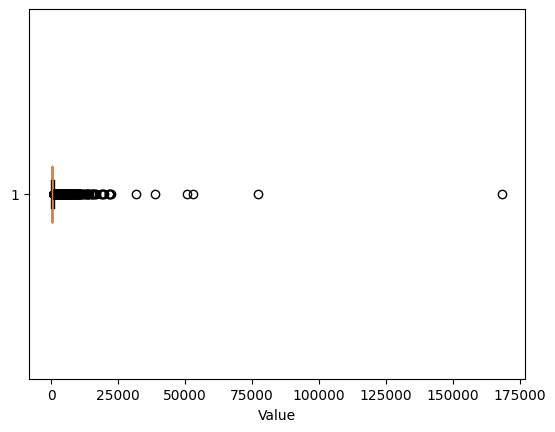

In [145]:
plt.boxplot(df_invoice_group.TotalPrice, vert=False)